Le but ici est de créer un référence (requêtes x document).
Idée de requête
- Utiliser le titre comme requête
- Utiliser les noun phrase du titre
- Les phrases citantes pour retrouver l'article cité

Cas possibles
- 1 req = 1 doc : très forte correlation entre topic et doc
- x req = 1 doc

Si 1 req = 1 doc alors il faut que les TC généré soient égal à la requête et en même temps différent des autres requetes, si il y a des requetes proches alors il faudra s'en éloigner donc peut-être 
Si 1 req = X doc

Ces couples (requête x document) vont être utilisés dans une loss.
L'idée est que grâce aux TC l'accuracy de RI doit augmenter.
L'accuracy serait un truc comme la cross entropy de la proba que le doc appartienne à la requete ou pas.
Est-ce que c'est dérivable si c'est à base de : est-ce que les termes de la requete sont dans les TC
Mais si c'est à base de cosine ça peut être ok, MAIS CONNE lors de l'entrainement on a pas de beam search, donc on sais pas quels sont les TC choisis.

In [1]:
import json
import spacy
import matplotlib.pyplot as plt
import nltk
nlp = spacy.load('en')
stopwords = nltk.corpus.stopwords.words('english')

In [2]:
with open('Documents/data/datasets/KP20k/full/kp20k.valid.json') as f:
    data = map(json.loads, f)
    data = {d['id']: d for d in data}

Topics are the noun chunk extracted from the title of the doc (tokenized on space)
The abstract and keyword are indexed.
The relevance score is how many token of topics appear (exactly) in the document.

In [5]:
%%time
topics = {k: [t
              for nc in nlp(v['title']).noun_chunks
              for t in nc.text.split() if t.lower() not in stopwords]
          for k, v in list(data.items())}

CPU times: user 2min 11s, sys: 76.1 ms, total: 2min 11s
Wall time: 2min 11s


In [6]:
def relevance_score(doc, topic):
    s = sum(t.lower() in doc.lower() for t in topic)
    return (s, s / len(topic))

In [7]:
def doc2content(doc):
    return doc['abstract'] + ' ' + ' '.join(t for k in doc['keyword'].split(';') for t in k.split())

In [8]:
doc2content(data['020000'])

'We investigate the problem of delay constrained maximal information collection for CSMA-based wireless sensor networks. We study how to allocate the maximal allowable transmission delay at each node, such that the amount of information collected at the sink is maximized and the total delay for the data aggregation is within the given bound. We formulate the problem by using dynamic programming and propose an optimal algorithm for the optimal assignment of transmission attempts. Based on the analysis of the optimal solution, we propose a distributed greedy algorithm. It is shown to have a similar performance as the optimal one. algorithms design performance sensor networks data aggregation real-time traffic csma/ca delay constrained transmission'

In [9]:
%time query2relevance = {k: {kd: relevance_score(doc2content(d), t) for kd, d in data.items()} for k, t in list(topics.items())[:100]}

CPU times: user 25.6 s, sys: 112 ms, total: 25.7 s
Wall time: 25.7 s


In [10]:
# Requêtes qui retournent trop de résultat

In [11]:
tmp = {k: (len(topics[k]), len({kd: s for kd, (_, s) in t.items() if s > 0.7}))
       for k, t in query2relevance.items()}
[(k, b, topics[k]) for k, (a, b) in tmp.items() if b > 150]

[]

In [12]:
topics['020006']

['volume',
 'subdivision',
 'hexahedral',
 'finite',
 'element',
 'meshing',
 'domains',
 'interior',
 '2-manifold',
 'boundaries']

In [13]:
data['023424']

{'abstract': 'In this work, the immersed element-free Galerkin method (IEFGM) is proposed for the solution of fluid-structure interaction (FSI) problems. In this technique, the FSI is represented as a volumetric force in the momentum equations. In IEFGM, a Lagrangian solid domain moves on top of ail Eulerian fluid domain that spans over the entire computational region. The fluid domain is modeled using the finite element method and the solid domain is modeled using file element-free Galerkin method. The continuity between the solid and fluid domains is satisfied by means of a local approximation, in the vicinity of the solid domain, of the velocity field and the FSI force. Such ail approximation is achieved using the moving least-squares technique. The method was applied to simulate the motion of a deformable disk moving in a viscous fluid due to the action of the gravitational force and the thermal convection of the fluid. Ail analysis of the main factors affecting the shape and traje

In [14]:
sorted(query2relevance['020006'].items(), reverse=True, key=lambda x: x[1][1])

[('020006', (7, 0.7)),
 ('023859', (7, 0.7)),
 ('023424', (5, 0.5)),
 ('039255', (5, 0.5)),
 ('022156', (4, 0.4)),
 ('022754', (4, 0.4)),
 ('023432', (4, 0.4)),
 ('024100', (4, 0.4)),
 ('024387', (4, 0.4)),
 ('024911', (4, 0.4)),
 ('025031', (4, 0.4)),
 ('025480', (4, 0.4)),
 ('026119', (4, 0.4)),
 ('026190', (4, 0.4)),
 ('028326', (4, 0.4)),
 ('028882', (4, 0.4)),
 ('028940', (4, 0.4)),
 ('029137', (4, 0.4)),
 ('030852', (4, 0.4)),
 ('034334', (4, 0.4)),
 ('036020', (4, 0.4)),
 ('036571', (4, 0.4)),
 ('036968', (4, 0.4)),
 ('037129', (4, 0.4)),
 ('038404', (4, 0.4)),
 ('039577', (4, 0.4)),
 ('020314', (3, 0.3)),
 ('020317', (3, 0.3)),
 ('021174', (3, 0.3)),
 ('021257', (3, 0.3)),
 ('021450', (3, 0.3)),
 ('021795', (3, 0.3)),
 ('021852', (3, 0.3)),
 ('022006', (3, 0.3)),
 ('022009', (3, 0.3)),
 ('022136', (3, 0.3)),
 ('022270', (3, 0.3)),
 ('022402', (3, 0.3)),
 ('022480', (3, 0.3)),
 ('022566', (3, 0.3)),
 ('022578', (3, 0.3)),
 ('023121', (3, 0.3)),
 ('023295', (3, 0.3)),
 ('023350',

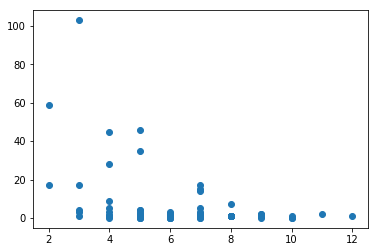

In [15]:
tmp = {k: (len(topics[k]), len({kd: s for kd, (_, s) in t.items() if s > 0.7}))
       for k, t in query2relevance.items()}
tmp = [(a, b) for a, b in tmp.values()]
plt.scatter([e[0] for e in tmp], [e[1] for e in tmp])
plt.show()

In [16]:
topics['020006']

['volume',
 'subdivision',
 'hexahedral',
 'finite',
 'element',
 'meshing',
 'domains',
 'interior',
 '2-manifold',
 'boundaries']